In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [ ]:
import transformers, nltk, pandas as pd, torch
from datasets import load_dataset, load_from_disk, DatasetDict, ClassLabel
from pprint import pprint
from textattack import Attack, AttackArgs,Attacker
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.loggers import CSVLogger # tracks a dataframe for us.
from textattack.attack_recipes import AttackRecipe
from textattack.search_methods import BeamSearch
from textattack.constraints.pre_transformation import RepeatModification, StopwordModification
from textattack.transformations import WordSwapEmbedding, WordSwapMaskedLM
from textattack.goal_functions import UntargetedClassification
from textattack.metrics.attack_metrics.attack_success_rate import AttackSuccessRate
from textattack.metrics.attack_metrics.words_perturbed import WordsPerturbed
from textattack.metrics.attack_metrics.attack_queries import AttackQueries
from textattack.metrics.quality_metrics.perplexity import Perplexity
from textattack.metrics.quality_metrics.use import USEMetric
from sentence_transformers.util import pytorch_cos_sim

from travis_attack.utils import display_all
from travis_attack.data import prep_dsd_rotten_tomatoes,prep_dsd_simple,prep_dsd_financial
from travis_attack.config import Config
from travis_attack.models import _prepare_vm_tokenizer_and_model, get_vm_probs, prepare_models, get_nli_probs

In [ ]:
class BeamSearchCFEmbeddingAttack(AttackRecipe):
    """Untarged classification + word embedding swap + [no repeat, no stopword] constraints + beam search"""
    @staticmethod
    def build(model_wrapper, beam_sz=2, max_candidates=5):
        goal_function = UntargetedClassification(model_wrapper)
        stopwords = nltk.corpus.stopwords.words("english") # The one used by default in textattack
        constraints = [RepeatModification(),
                       StopwordModification(stopwords)]
        transformation = WordSwapEmbedding(max_candidates=max_candidates)
        search_method = BeamSearch(beam_width=beam_sz)
        attack = Attack(goal_function, constraints, transformation, search_method)
        return attack

class BeamSearchLMAttack(AttackRecipe): 
    """"""
    @staticmethod
    def build(model_wrapper, beam_sz=2, max_candidates=5):
        stopwords = nltk.corpus.stopwords.words("english") # The one used by default in textattack
        goal_function = UntargetedClassification(model_wrapper)
        constraints = [RepeatModification(),
                       StopwordModification()]
        transformation = WordSwapMaskedLM(method='bae', masked_language_model='distilroberta-base', max_candidates=max_candidates)
        search_method = BeamSearch(beam_width=beam_sz)
        attack = Attack(goal_function, constraints, transformation, search_method)
        return attack

In [ ]:
######### CONFIG #########
ds_name = "rotten_tomatoes" 
split='valid'
beam_sz=5
num_examples=4
max_candidates=25
attack_recipe = BeamSearchLMAttack
filename = f"/data/tproth/travis_attack/baselines/{ds_name}_{split}_{attack_recipe.__name__}_beam_sz={beam_sz}_max_candidates={max_candidates}_tmp.csv"
##########################

## Attack 

In [ ]:
if ds_name == "financial_phrasebank":
    cfg = Config().adjust_config_for_financial_dataset()
    dsd = prep_dsd_financial(cfg)
elif ds_name == "rotten_tomatoes":      
    cfg = Config().adjust_config_for_rotten_tomatoes_dataset()
    dsd = prep_dsd_rotten_tomatoes(cfg)
elif ds_name == "simple":      
    cfg = Config().adjust_config_for_simple_dataset()
    dataset = prep_dsd_simple(cfg)
    #dataset = ...
dataset = HuggingFaceDataset(dsd[split])


Using custom data configuration default
Reusing dataset rotten_tomatoes_movie_review (/data/tproth/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


In [ ]:
vm_tokenizer, vm_model, _,_, sts_model, nli_tokenizer, nli_model, cfg = prepare_models(cfg)
model_wrapper = HuggingFaceModelWrapper(vm_model, vm_tokenizer)
attack = attack_recipe.build(model_wrapper, beam_sz, max_candidates)
attack_args = AttackArgs(num_examples=num_examples, enable_advance_metrics=True,
                        log_to_csv=filename, csv_coloring_style='plain', disable_stdout=True)
attacker = Attacker(attack, dataset, attack_args)

textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [ ]:
attack_results = attacker.attack_dataset()

textattack: Logging to CSV at path /data/tproth/travis_attack/baselines/rotten_tomatoes_valid_BeamSearchLMAttack_beam_sz=5_max_candidates=25_tmp.csv
  0%|          | 0/4 [00:00<?, ?it/s]

Attack(
  (search_method): BeamSearch(
    (beam_width):  5
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  RobertaForMaskedLM
    (max_length):  512
    (max_candidates):  25
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4: 100%|██████████| 4/4 [01:09<00:00, 17.25s/it]



+-------------------------------+---------+
| Attack Results                |         |
+-------------------------------+---------+
| Number of successful attacks: | 3       |
| Number of failed attacks:     | 1       |
| Number of skipped attacks:    | 0       |
| Original accuracy:            | 100.0%  |
| Accuracy under attack:        | 25.0%   |
| Attack success rate:          | 75.0%   |
| Average perturbed word %:     | 10.72%  |
| Average num. words per input: | 16.0    |
| Avg num queries:              | 2026.75 |
| Average Original Perplexity:  | 179.37  |
| Average Attack Perplexity:    | 294.71  |
| Average Attack USE Score:     | 0.87    |
+-------------------------------+---------+


## General metrics 

In [ ]:
metrics = {
    **AttackSuccessRate().calculate(attack_results), 
    **WordsPerturbed().calculate(attack_results),
    **AttackQueries().calculate(attack_results),
    **Perplexity().calculate(attack_results),
    **USEMetric().calculate(attack_results)
}

## Example-specific metrics 

In [ ]:
def display_adv_example(df): 
    from IPython.core.display import display, HTML
    pd.options.display.max_colwidth = 480 # increase column width so we can actually read the examples
    display(HTML(df[['original_text', 'perturbed_text']].to_html(escape=False)))

def add_vm_score_and_label_flip(df, dataset,  cfg, vm_tokenizer, vm_model): 
    truelabels = torch.tensor(dataset._dataset['label'], device =cfg.device)
    orig_probs =  get_vm_probs(df['original_text'].tolist(), cfg, vm_tokenizer, vm_model, return_predclass=False)
    pp_probs = get_vm_probs(df['perturbed_text'].tolist(), cfg, vm_tokenizer, vm_model, return_predclass=False)
    orig_predclass = torch.argmax(orig_probs, axis=1)
    pp_predclass = torch.argmax(pp_probs, axis=1)
    orig_truelabel_probs = torch.gather(orig_probs, 1, truelabels[:,None]).squeeze()
    pp_truelabel_probs   = torch.gather(pp_probs, 1,   truelabels[:,None]).squeeze()
    pp_predclass_probs   = torch.gather(pp_probs, 1,   pp_predclass[ :,None]).squeeze()
    
    df['truelabel'] = truelabels.cpu().tolist()
    df['orig_predclass'] = orig_predclass.cpu().tolist()
    df['pp_predclass'] = pp_predclass.cpu().tolist()
    df['orig_truelabel_probs'] = orig_truelabel_probs.cpu().tolist()
    df['pp_truelabel_probs'] = pp_truelabel_probs.cpu().tolist()
    df['vm_scores'] = (orig_truelabel_probs - pp_truelabel_probs).cpu().tolist()
    df['label_flip'] = ((pp_predclass != truelabels) * 1).cpu().tolist()
    return df

def add_sts_score(df, sts_model, cfg): 
    orig_embeddings  = sts_model.encode(df['original_text'].tolist(),  convert_to_tensor=True, device=cfg.device)
    pp_embeddings    = sts_model.encode(df['perturbed_text'].tolist(), convert_to_tensor=True, device=cfg.device)
    df['sts_scores'] = pytorch_cos_sim(orig_embeddings, pp_embeddings).diagonal().cpu().tolist()
    return df

def add_contradiction_score(df, cfg, nli_tokenizer, nli_model): 
    contradiction_scores = get_nli_probs(df['original_text'].tolist(), df['perturbed_text'].tolist(), cfg,  nli_tokenizer, nli_model)
    df['contradiction_scores'] =  contradiction_scores.cpu().tolist()

In [ ]:
filename = f"/data/tproth/travis_attack/baselines/{ds_name}_{split}_{attack_recipe.__name__}_beam_sz={beam_sz}_max_candidates={max_candidates}.csv"
df = pd.read_csv(filename)
#display_adv_example(df)
df = add_vm_score_and_label_flip(df,dataset,  cfg, vm_tokenizer, vm_model)
df = df.query("result_type != 'Skipped'")
df = add_sts_score(df, sts_model, cfg)
df = add_contradiction_score(df, cfg, nli_tokenizer, nli_model)

NameError: name 'nli_tokenizer' is not defined

In [ ]:
display_all(df.sample(2))

,ground_truth_output,num_queries,original_output,original_score,original_text,perturbed_output,perturbed_score,perturbed_text,result_type,truelabel,orig_predclass,pp_predclass,orig_truelabel_probs,pp_truelabel_probs,vm_scores,label_flip,sts_scores
294,1.0,3966.0,1.0,0.046687,"assured , vital and well wrought , the film is , arguably , the most accomplished work to date from hong kong's versatile stanley kwan .",0.0,0.879079,"assured , vital and poorly plotted , the film is , unfortunately , the most underrated work to date from hong kong's versatile stanley kwan .",Successful,1,1,0,0.953313,0.120921,0.832392,1,0.639580
116,1.0,1492.0,1.0,0.052343,an ebullient tunisian film about the startling transformation of a tradition-bound widow who is drawn into the exotic world of belly dancing .,0.0,0.657411,an obscure tunisian film about the slow transformation of a tradition-bound widow who is drawn into the exotic world of belly dancing .,Successful,1,1,0,0.947657,0.342589,0.605069,1,0.978464


In [ ]:
df1 = df.sample(5)
orig_l = df1['original_text'].tolist()
pp_l = df1['perturbed_text'].tolist()
print(orig_l)
print(pp_l)

["[stephen] earnhart's film is more about the optimism of a group of people who are struggling to give themselves a better lot in life than the ones they currently have .", "the irwins' scenes are fascinating ; the movie as a whole is cheap junk and an insult to their death-defying efforts .", 'the story , touching though it is , does not quite have enough emotional resonance or variety of incident to sustain a feature , and even at 85 minutes it feels a bit long .', 'starts out strongly before quickly losing its focus , point and purpose in a mess of mixed messages , over-blown drama and bruce willis with a scar .', 'a guilty pleasure at best , and not worth seeing unless you want to laugh at it .']
["[stephen] earnhart's rant is more about the frustration of a group of people who are struggling to give themselves a better lot in life than the ones they currently have .", "the irwins' scenes are fascinating ; the movie as a whole is cheap fun and an insult to their death-defying effor

In [ ]:
for orig, adv in zip(df1['original_text'].tolist(), df1['perturbed_text'].tolist()): 
    print(f"{orig}{adv}")
    print()

long before it's over , you'll be thinking of 51 ways to leave this loser .long before it's over , you'll be thinking of innovative ways to leave this loser .

jaunty fun , with its celeb-strewn backdrop well used .jaunty fun , with its celeb-strewn backdrop badly used .

. . . by the time it's done with us , mira nair's new movie has its audience giddy with the delight of discovery , of having been immersed in a foreign culture only to find that human nature is pretty much the same all over .. . . by the time it's done with us , mira nair's new movie has its audience struggling with the idea of discovery , of having been immersed in a foreign culture only to find that human nature is pretty much the same all over .

as a feature-length film , it wears out its welcome as tryingly as the title character .as a feature-length film , it holds out its welcome as tryingly as the title character .

brosnan is more feral in this film than i've seen him before and halle berry does her best to k

<AxesSubplot:>

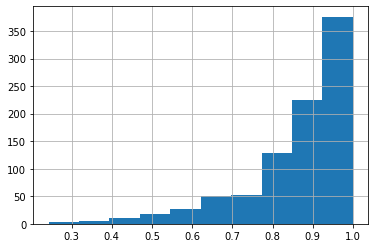

In [ ]:
df.sts_scores.hist()